## **Установка требуемых библиотек**

In [46]:
!pip install transformers datasets torch pymorphy3 gensim stop_words

### **Загрузка библиотек**

In [47]:
import nltk
import re
import pymorphy3
import torch
import numpy as np
import pandas as ps
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('punkt_tab')
RUSSIAN_STOP_WORDS = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### **Анализ датасета**

In [49]:
dataset = load_dataset("MonoHime/ru_sentiment_dataset")

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 189891
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text', 'sentiment'],
        num_rows: 21098
    })
})

In [51]:
dataset['train'][0]

{'Unnamed: 0': 21098,
 'text': '.с.,и спросил его:  о Посланник Аллаха!Ты порицаешь что-то из слушания?  Он ответил: я не порицаю ничего из него,но передай им,чтобы они открывали свои собрания Кораном и закрывали их Кораном ...........Это дошедшие до нас мнения и тот кто находится в поисках истины,по мере изучения этого вопроса будет сталкиваться с разногласиями и будет оставаться в растерянности или склонится к мнению одной из сторон по своему желанию.Но всего этого недостаточно,потому что он сам должен найти истину,подробно изучив вопросы запретного и разрешённого.|||||||||||||||||||||||||||||||||||||Обрати внимание:основатели всех четырёх мазхабов осуждали песни и поэззию.И этим часто грешат заблудшие суфии.Исключение делается для исламской тематики  Сахих БухариО проявлении радости во время праздника.498 (949). Сообщается, что ‘Аиша, да будет доволен ею Аллах, сказала: (Однажды) посланник Аллаха, да благословит его Аллах и приветствует, вошёл ко мне в то время, когда у меня находил

In [52]:
lengths = [len(text.split()) for text in dataset['train']['text']]
max_len = np.percentile(lengths, 95)

dataset = dataset.filter(
    lambda x: 3 <= len(x['text'].split()) <= max_len
)

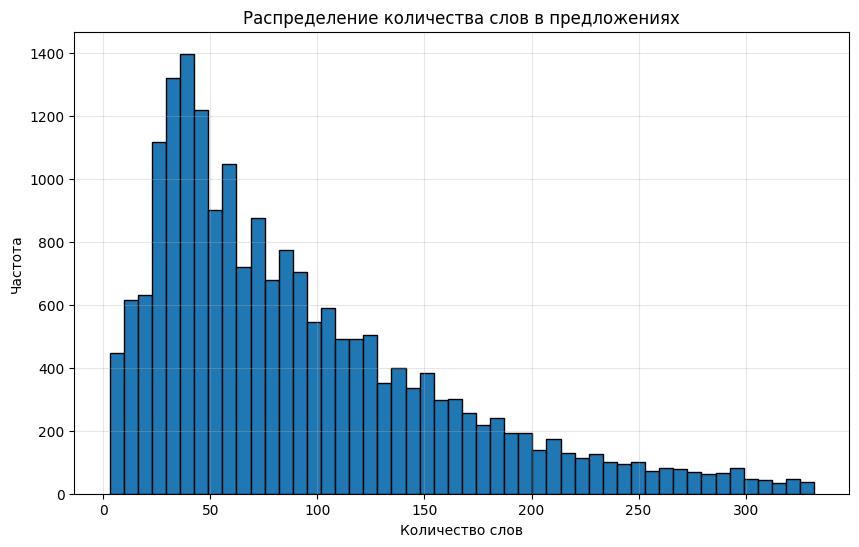

In [53]:
texts = dataset['validation']['text']

word_counts = [len(text.split()) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title('Распределение количества слов в предложениях')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

In [54]:
subset = dataset['train'].select(range(30000))
split_data = subset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_data['train']
test_dataset = split_data['test']

## **Лемматизация и очистка текста**

In [55]:
morph = pymorphy3.MorphAnalyzer()

def preproc_nltk(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'@\w+\b', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    tokens = word_tokenize(text, language='russian')
    lemmas = [
        morph.parse(token)[0].normal_form
        for token in tokens
        if (token not in RUSSIAN_STOP_WORDS and len(token) >= 2)
    ]

    return ' '.join(lemmas)


train_dataset = train_dataset.map(lambda x: {'text': preproc_nltk(x['text'])})

In [56]:
train_texts = train_dataset['text']
train_labels = list(train_dataset['sentiment'])

In [184]:
bow_vectorizer = CountVectorizer(
    min_df=0.05,
    max_df=0.9,
    binary=False)

bow_vectors = bow_vectorizer.fit_transform(train_texts)

In [185]:
X_train, X_test, y_train, y_test = train_test_split(bow_vectors, train_labels, test_size=0.2, random_state=42)

In [186]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [187]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.62625


## **Наивный байесовский классификатор на мешке слов**

In [188]:
nb = BernoulliNB(binarize=True)
nb.fit(X_train, y_train)

BernoulliNB(binarize=True)

In [189]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5041666666666667


## **TF-IDF**

In [190]:
vectorizer = TfidfVectorizer(min_df=50, max_df=5000)
vectors = vectorizer.fit_transform(train_dataset['text'])

In [191]:
dense_vectors = vectors.todense()
dense_vectors.shape

(24000, 3342)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(vectors, train_labels, test_size=0.2, random_state=42)

In [193]:
nb = BernoulliNB()
nb.fit(X_train, y_train)

BernoulliNB()

In [194]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6045833333333334


In [195]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [196]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.705625


## Использование эмбеддингов
#### Oбучение модели на основе самого текста

In [197]:
proc_words = [preproc_nltk(text).split() for text in tqdm(train_dataset['text'], desc="Tokenizing")]

Tokenizing: 100%|██████████| 24000/24000 [02:08<00:00, 187.43it/s]


In [198]:
model = Word2Vec(
    sentences=proc_words,
    vector_size=100,
    window=3,
    min_count=50,
    workers=4,
    epochs=10)

In [199]:
def vectorize_sum(comment, embeddings, max_length=60):
    embedding_dim = embeddings.vector_size
    features = np.zeros([max_length, embedding_dim], dtype='float32')
    words = preproc_nltk(comment).split()[:max_length]

    for i, word in enumerate(words):
        if word in embeddings.wv:
            features[i] = embeddings.wv[word]

    return features

In [200]:
X_wv = np.stack([vectorize_sum(text, model) for text in train_dataset['text']])

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_wv, train_labels, test_size=0.3, random_state=0)

In [202]:
X_train.shape

(16800, 60, 100)

In [203]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)
clf.fit(X_train_flattened, y_train)
y_pred = clf.predict(X_test_flattened)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5913888888888889


In [204]:
MAX_LEN = 150
EMBED_DIM = 256
NHEAD = 8
FFN_HID_DIM = 256
NUM_LAYERS = 8
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-4
num_classes = 3

In [207]:
def build_vocab(texts, min_df=2):
    vectorizer = CountVectorizer(
        min_df=min_df,
        tokenizer=lambda x: x.split(),
        token_pattern=None
    )
    vectorizer.fit(texts)
    vocab = {word: idx+2 for idx, word in enumerate(vectorizer.get_feature_names_out())}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

vocab = build_vocab(train_texts)
VOCAB_SIZE = len(vocab)

In [208]:
VOCAB_SIZE

31143

In [209]:
class CommentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Теперь texts[idx] работает, так как это обычный список
        tokens = self.texts[idx].split()
        token_ids = [self.vocab.get(t, self.vocab['<unk>']) for t in tokens[:self.max_len]]

        if len(token_ids) < self.max_len:
            token_ids += [self.vocab['<pad>']] * (self.max_len - len(token_ids))

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Подготавливаем данные как списки
train_texts_list = list(train_dataset['text'])
train_labels_list = list(train_dataset['sentiment'])

# Разделяем на train/val
texts_train, texts_val, labels_train, labels_val = train_test_split(
    train_texts_list,  # Используем список
    train_labels_list,  # Используем список
    test_size=0.1,
    random_state=42
)

# labels уже в правильном формате, так как мы сделали list()

train_data = CommentDataset(texts_train, labels_train, vocab, MAX_LEN)
val_data = CommentDataset(texts_val, labels_val, vocab, MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [210]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value):
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention

In [211]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, nhead, dim_feedforward=128, dropout=0.2):
        super().__init__()
        self.self_attn = MultiHeadAttentionLayer(emb_size, nhead, dropout, device=device)
        self.linear1 = nn.Linear(emb_size, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, emb_size)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src):
        src2, _ = self.self_attn(src, src, src)
        src = self.norm1(src + self.dropout(src2))

        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout(src2))
        return src


class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len):
        super().__init__()
        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [212]:
class TextTransformer(nn.Module):
    def __init__(self, num_classes, vocab_size, emb_size, nhead, num_layers, dim_feedforward, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, MAX_LEN)

        self.layers = nn.ModuleList([
            EncoderBlock(emb_size, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)

        for layer in self.layers:
            src = layer(src)

        output = src.mean(dim=1)
        return self.classifier(output)

In [213]:
import torch.optim as optim
import torch.nn as nn
import math

model = TextTransformer(
    num_classes=num_classes,
    vocab_size=VOCAB_SIZE,
    emb_size=EMBED_DIM,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=FFN_HID_DIM
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [214]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            predicted = torch.argmax(outputs, dim=1)

            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total if val_total > 0 else 0

    print(f"Epoch {epoch+1}, "
          f"Loss: {total_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, "
          f"Val Acc: {val_acc:.2f}%")

Epoch 1 [Val]: 100%|██████████| 75/75 [00:01<00:00, 44.96it/s]


Epoch 1, Loss: 0.8407, Train Acc: 57.33%, Val Acc: 63.54%


Epoch 2 [Val]: 100%|██████████| 75/75 [00:01<00:00, 44.06it/s]


Epoch 2, Loss: 0.6620, Train Acc: 67.88%, Val Acc: 69.67%


Epoch 3 [Val]: 100%|██████████| 75/75 [00:01<00:00, 43.52it/s]


Epoch 3, Loss: 0.5858, Train Acc: 72.57%, Val Acc: 71.04%


Epoch 4 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.74it/s]


Epoch 4, Loss: 0.5267, Train Acc: 75.62%, Val Acc: 71.96%


Epoch 5 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.51it/s]


Epoch 5, Loss: 0.4679, Train Acc: 78.87%, Val Acc: 71.92%


Epoch 6 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.83it/s]


Epoch 6, Loss: 0.3956, Train Acc: 82.71%, Val Acc: 70.12%


Epoch 7 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.26it/s]


Epoch 7, Loss: 0.3411, Train Acc: 85.50%, Val Acc: 72.33%


Epoch 8 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.95it/s]


Epoch 8, Loss: 0.2771, Train Acc: 88.37%, Val Acc: 71.88%


Epoch 9 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.14it/s]


Epoch 9, Loss: 0.2266, Train Acc: 90.69%, Val Acc: 70.79%


Epoch 10 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.11it/s]


Epoch 10, Loss: 0.1885, Train Acc: 92.45%, Val Acc: 71.50%


Epoch 11 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.98it/s]


Epoch 11, Loss: 0.1520, Train Acc: 94.06%, Val Acc: 69.96%


Epoch 12 [Val]: 100%|██████████| 75/75 [00:01<00:00, 41.27it/s]


Epoch 12, Loss: 0.1345, Train Acc: 94.77%, Val Acc: 70.71%


Epoch 13 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.10it/s]


Epoch 13, Loss: 0.1067, Train Acc: 96.02%, Val Acc: 70.08%


Epoch 14 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.04it/s]


Epoch 14, Loss: 0.0975, Train Acc: 96.47%, Val Acc: 70.62%


Epoch 15 [Val]: 100%|██████████| 75/75 [00:01<00:00, 42.15it/s]

Epoch 15, Loss: 0.0809, Train Acc: 96.96%, Val Acc: 70.71%


In [216]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## **Создадим фукнцию**

In [44]:
test_texts = test_dataset['text']
test_labels = test_dataset['sentiment']

In [31]:
def test_model(model_name, test_texts, test_labels, batch_size):
  try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
        )
        model.to(device)
        model.eval()
        predictions = []
        for i in tqdm(range(0, len(test_texts), batch_size)):
            batch_texts = test_texts[i:i + batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)

        predictions = np.array(predictions)
        acc = accuracy_score(test_labels, predictions)
        f1_m = f1_score(test_labels, predictions, average='macro')
        f1_w = f1_score(test_labels, predictions, average='weighted')
        print(classification_report(
            test_labels,
            predictions,
            target_names=['Позитивный', 'Нейтральный', 'Негативный'],
            digits=4
        ))
        return {
            'model': model_name,
            'accuracy': acc,
            'f1_macro': f1_m,
            'f1_weighted': f1_weighted,
            'predictions': f1_w
        }

  except Exception as e:
    print(f"{model}: {e}")
    return None

In [32]:
models = {
    "BERT Мультиязычный": "bert-base-multilingual-cased",
    "RuBERT": "DeepPavlov/rubert-base-cased",
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"
}

In [33]:
results = {}

for model_label, model_name in models.items():
    result = test_model(model_name, test_texts, test_labels, batch_size=32)
    if result:
        results[model_label] = result

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 188/188 [01:38<00:00,  1.91it/s]


              precision    recall  f1-score   support

  Позитивный     0.2455    0.0363    0.0633      1514
 Нейтральный     0.4960    0.7447    0.5954      2903
  Негативный     0.2209    0.1977    0.2087      1583

    accuracy                         0.4217      6000
   macro avg     0.3208    0.3263    0.2891      6000
weighted avg     0.3602    0.4217    0.3591      6000

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 188/188 [01:35<00:00,  1.98it/s]


              precision    recall  f1-score   support

  Позитивный     0.5000    0.0007    0.0013      1514
 Нейтральный     0.4940    0.2856    0.3619      2903
  Негативный     0.2819    0.7694    0.4127      1583

    accuracy                         0.3413      6000
   macro avg     0.4253    0.3519    0.2586      6000
weighted avg     0.4396    0.3413    0.2843      6000

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 188/188 [01:31<00:00,  2.06it/s]


              precision    recall  f1-score   support

  Позитивный     0.2860    0.0945    0.1420      1514
 Нейтральный     0.4894    0.9270    0.6406      2903
  Негативный     0.0000    0.0000    0.0000      1583

    accuracy                         0.4723      6000
   macro avg     0.2585    0.3405    0.2609      6000
weighted avg     0.3089    0.4723    0.3458      6000

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
  

## **Квантованные версии моделей**

In [ ]:
#!pip install bitsandbytes accelerate

In [36]:
from transformers import BitsAndBytesConfig

def test_quantized_model(model_name, test_texts, test_labels, batch_size=16):

    try:
        quantization_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_skip_modules=None,
            llm_int8_has_fp16_weight=False
        )

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
            quantization_config=quantization_config,
            device_map="auto",
            ignore_mismatched_sizes=True
        )
        model.eval()

        predictions = []

        for i in tqdm(range(0, len(test_texts), batch_size)):
            batch_texts = test_texts[i:i + batch_size]

            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt"
            )

            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model(**inputs)
                batch_predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
                predictions.extend(batch_predictions)

        predictions = np.array(predictions)

        accuracy = accuracy_score(test_labels, predictions)
        f1_macro = f1_score(test_labels, predictions, average='macro')
        f1_weighted = f1_score(test_labels, predictions, average='weighted')

        print(classification_report(
            test_labels,
            predictions,
            target_names=['Позитивный', 'Нейтральный', 'Негативный'],
            digits=4
        ))

        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated() / 1024**3

        del model
        torch.cuda.empty_cache()

        return {
            'model': model_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'predictions': predictions
        }

    except Exception as e:
        print(f"Ошибка при тестировании {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None

In [37]:
models = {
    "BERT Мультиязычный": "bert-base-multilingual-cased",
    "RuBERT": "DeepPavlov/rubert-base-cased",
    "RuBERT на диалогах": "DeepPavlov/rubert-base-cased-conversational"
}

In [38]:
results = {}

for model_label, model_name in models.items():
    result = test_quantized_model(model_name, test_texts, test_labels, batch_size=16)
    if result:
        results[model_label] = result

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 375/375 [01:08<00:00,  5.48it/s]


              precision    recall  f1-score   support

  Позитивный     0.2427    0.0661    0.1038      1514
 Нейтральный     0.4876    0.5153    0.5011      2903
  Негативный     0.2667    0.4245    0.3276      1583

    accuracy                         0.3780      6000
   macro avg     0.3323    0.3353    0.3108      6000
weighted avg     0.3675    0.3780    0.3551      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 375/375 [01:07<00:00,  5.53it/s]


              precision    recall  f1-score   support

  Позитивный     0.2474    0.0786    0.1193      1514
 Нейтральный     0.3556    0.0110    0.0214      2903
  Негативный     0.2638    0.9046    0.4084      1583

    accuracy                         0.2638      6000
   macro avg     0.2889    0.3314    0.1830      6000
weighted avg     0.3040    0.2638    0.1482      6000



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 375/375 [00:55<00:00,  6.71it/s]


              precision    recall  f1-score   support

  Позитивный     0.2500    0.0053    0.0103      1514
 Нейтральный     0.4836    0.1471    0.2256      2903
  Негативный     0.2633    0.8459    0.4016      1583

    accuracy                         0.2957      6000
   macro avg     0.3323    0.3327    0.2125      6000
weighted avg     0.3665    0.2957    0.2177      6000



In [39]:
results_data = {
    model: {
        'acc': info['accuracy'],
        'f1_m': info['f1_macro'],
        'f1_w': info['f1_weighted']
    }
    for model, info in results.items()
}

In [40]:
results_data

{'BERT Мультиязычный': {'acc': 0.378,
  'f1_m': 0.3108319836633535,
  'f1_w': 0.35506882110305027},
 'RuBERT': {'acc': 0.2638333333333333,
  'f1_m': 0.1830413809513369,
  'f1_w': 0.14820963325522094},
 'RuBERT на диалогах': {'acc': 0.2956666666666667,
  'f1_m': 0.21251228207350384,
  'f1_w': 0.2177093884108323}}

In [29]:
!pip install peft

In [57]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from sklearn.metrics import classification_report, f1_score
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import warnings
import os
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return {
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted')
    }

def preprocess(examples, tokenizer):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)
    tokenized['labels'] = examples['sentiment']
    return tokenized

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_train = train_dataset.map(lambda x: preprocess(x, tokenizer), batched=True, remove_columns=['text', 'Unnamed: 0'])
tokenized_test = test_dataset.map(lambda x: preprocess(x, tokenizer), batched=True, remove_columns=['text', 'Unnamed: 0'])

bnb_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, quantization_config=bnb_config, device_map="auto")
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(r=4, lora_alpha=32, target_modules=["query", "value"], lora_dropout=0.05, bias="none", task_type="SEQ_CLS")
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

training_args = TrainingArguments(
    output_dir="./results/BERT_QLoRA",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=torch.cuda.is_available(),
    learning_rate=2e-4,
    max_grad_norm=0.3,
    report_to="none"
)

trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_test, compute_metrics=compute_metrics)
trainer.train()

predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print(f"\nF1-macro: {predictions.metrics['test_f1_macro']:.4f}")
print(f"F1-weighted: {predictions.metrics['test_f1_weighted']:.4f}")
print("\n", classification_report(true_labels, pred_labels, target_names=['Позитивный', 'Нейтральный', 'Негативный'], digits=4))

model.save_pretrained("./results/BERT_QLoRA")
tokenizer.save_pretrained("./results/BERT_QLoRA")

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 149,763 || all params: 178,005,510 || trainable%: 0.0841


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted
1,0.691900,0.794514,0.527074,0.566524



F1-macro: 0.5271
F1-weighted: 0.5665

               precision    recall  f1-score   support

  Позитивный     0.4936    0.3540    0.4123      1514
 Нейтральный     0.5881    0.8657    0.7004      2903
  Негативный     0.8128    0.3291    0.4685      1583

    accuracy                         0.5950      6000
   macro avg     0.6315    0.5163    0.5271      6000
weighted avg     0.6235    0.5950    0.5665      6000



('./results/BERT_QLoRA/tokenizer_config.json',
 './results/BERT_QLoRA/special_tokens_map.json',
 './results/BERT_QLoRA/vocab.txt',
 './results/BERT_QLoRA/added_tokens.json',
 './results/BERT_QLoRA/tokenizer.json')

In [ ]:
from huggingface_hub import login

login()

In [61]:
from huggingface_hub import HfApi

api = HfApi()

repo_id = "Renan1997/bert-multilingual-sentiment-qlora"
api.create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)

api.upload_folder(
    folder_path="./results/BERT_QLoRA",
    repo_id=repo_id,
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../checkpoint-750/scaler.pt: 100%|##########| 1.38kB / 1.38kB            

  ...eckpoint-750/scheduler.pt: 100%|##########| 1.47kB / 1.47kB            

  ...ckpoint-750/rng_state.pth:  82%|########2 | 12.1kB / 14.6kB            

  ...adapter_model.safetensors:  23%|##2       |  137kB /  606kB            

  ...adapter_model.safetensors:  23%|##2       |  137kB /  606kB            

  ...eckpoint-750/optimizer.pt:  23%|##2       |  282kB / 1.24MB            

  ...int-750/training_args.bin:  23%|##2       | 1.32kB / 5.84kB            

CommitInfo(commit_url='https://huggingface.co/Renan1997/bert-multilingual-sentiment-qlora/commit/232d8c397cd791d7b32764e15b0cc71791279015', commit_message='Upload folder using huggingface_hub', commit_description='', oid='232d8c397cd791d7b32764e15b0cc71791279015', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Renan1997/bert-multilingual-sentiment-qlora', endpoint='https://huggingface.co', repo_type='model', repo_id='Renan1997/bert-multilingual-sentiment-qlora'), pr_revision=None, pr_num=None)